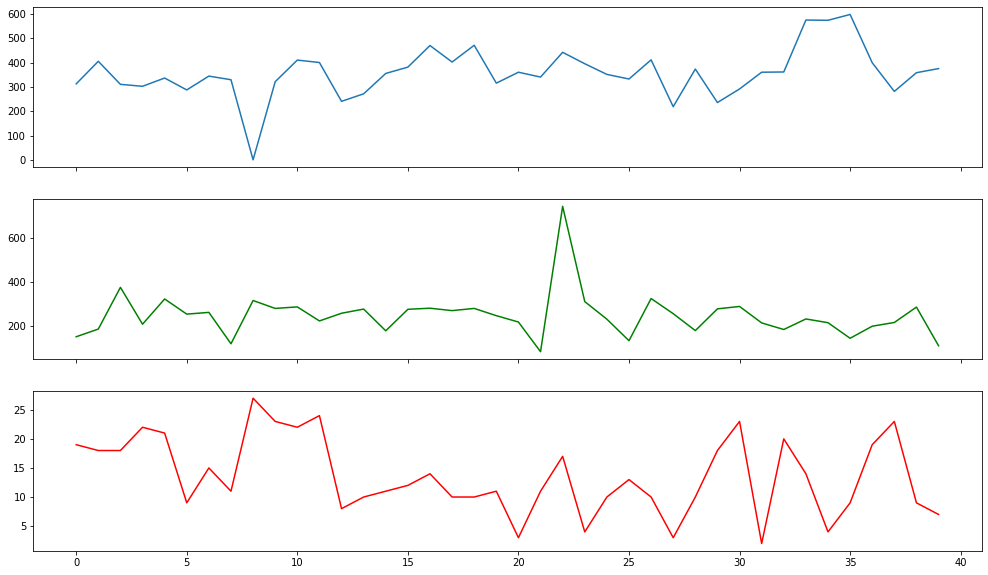

,Confirmed daily,Recovered,Official deaths daily
98,292.0,288.0,23.0
99,361.0,213.0,2.0
100,362.0,183.0,20.0
101,576.0,231.0,14.0
102,575.0,214.0,4.0
103,599.0,143.0,9.0
104,400.0,198.0,19.0
105,282.0,215.0,23.0
106,359.0,285.0,9.0
107,376.0,109.0,7.0


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv("/home/jan/Documents/GIT/Hackaton/data/covid19.csv")
data = data.fillna(0)
data = data.drop(["Source","Unofficial deaths daily"], axis = 1)
data_train = data[["Confirmed daily", "Recovered", "Official deaths daily"]]
data_train = data_train.iloc[-40:,:]

fig, axes = plt.subplots(3,1, sharex=True, figsize=(17, 10))
axes[0].plot(range(data_train.shape[0]), data_train["Confirmed daily"] )
axes[1].plot(range(data_train.shape[0]), data_train["Recovered"] ,"g")
axes[2].plot(range(data_train.shape[0]), data_train["Official deaths daily"], "r" )
plt.show()

data_train.iloc[-10:,:]

In [4]:
print(data_train.corr())
print(np.sqrt(data_train.cov()))
print("\n Mean values:\n",data_train.mean())

                       Confirmed daily  Recovered  Official deaths daily
Confirmed daily               1.000000  -0.029286              -0.297122
Recovered                    -0.029286   1.000000               0.175851
Official deaths daily        -0.297122   0.175851               1.000000
                       Confirmed daily   Recovered  Official deaths daily
Confirmed daily             102.923543         NaN                    NaN
Recovered                          NaN  103.530003              10.979001
Official deaths daily              NaN   10.979001               6.620868

 Mean values:
 Confirmed daily          358.225
Recovered                246.500
Official deaths daily     13.600
dtype: float64


/home/jan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


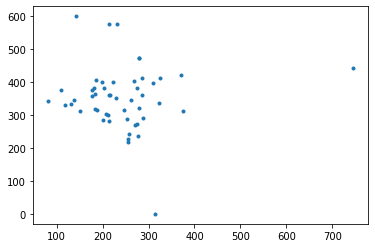

In [5]:
plt.plot(data_train["Recovered"], data_train["Confirmed daily"], "." )
plt.show()


In [31]:
SEIR_init_unnorm = np.norm([35979104, 1081, 5777, 14037, 0, 0])
SEIR_init = [a/sum(SEIR_init_unnorm) for a in SEIR_init_unnorm]
SEIR_init

[0.9994195833172107,
 3.002777861188274e-05,
 0.00016047222667978407,
 0.0003899166774976855,
 0.0,
 0.0]

Beta, gamma, sigma, delta, ni:  -1.3862943611198906 -1.3862943611198906 -1.6094379124341003 -4.0943445622221 -6.684611727667927
SEIR:  [0.9994195833172107, 3.002777861188274e-05, 0.00016047222667978407, 0.0003899166774976855, 0.0, 0.0]


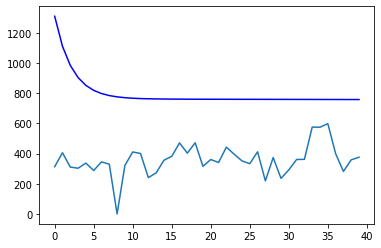

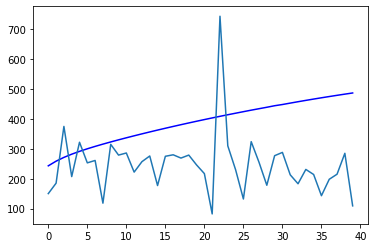

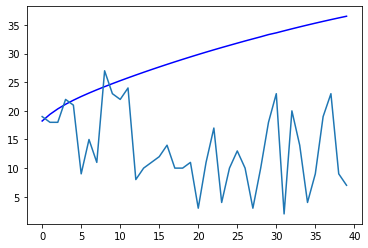

In [43]:
from functools import reduce
from scipy.integrate import odeint
R_obs_w = list(data_train["Confirmed daily"])
O_obs_w = list(data_train["Recovered"])
Z_obs_w = list(data_train["Official deaths daily"])
SEIR_init_unnorm = [35979104, 1081, 5777, 14037, 0, 0]
N = (35979104 + 1081.588 + 5777.911 + 14037.00)
SEIR_init = [a/sum(SEIR_init_unnorm) for a in SEIR_init_unnorm]
def system(y, t, beta, sigma, gamma, delta, ni):
    Sw, Ew, Iw, Rw, Ow, Zw = y
    dydt = [-np.exp(beta)*Iw*Sw, np.exp(beta)*Iw*Sw - np.exp(sigma)*Ew, np.exp(sigma)*Ew - np.exp(gamma)*Iw, np.exp(gamma)*Iw - (np.exp(delta) + np.exp(ni))*Rw, np.exp(delta)*Rw, np.exp(ni)*Rw]
    return dydt

def Rw_solution(y0, beta, sigma, gamma, delta, ni, t = np.linspace(0, len(R_obs_w), num = len(R_obs_w)+1)):
    solution = odeint(system, y0, t, args=(beta, sigma, gamma, delta, ni))
    R_change = solution[1:,3] - solution[:len(solution)-1,3]
    O_change = solution[1:,4] - solution[:len(solution)-1,4]
    Z_change = solution[1:,5] - solution[:len(solution)-1,5]
    return R_change + O_change + Z_change, O_change, Z_change

# Visualization of SEIR solution

i_beta, i_gamma, i_sigma, i_delta, i_ni = np.log(1/4), np.log(1/4), np.log(1/5) , np.log(1/60), np.log(1/800)
print("Beta, gamma, sigma, delta, ni: ",i_beta, i_gamma, i_sigma,i_delta, i_ni)
print("SEIR: ",SEIR_init)
R_SEIR_w, O_SEIR_w, Z_SEIR_w = Rw_solution(SEIR_init, beta = i_beta, gamma =  i_gamma, sigma = i_sigma, delta = i_delta, ni = i_ni)

plt.plot(range(len(R_obs_w)),[a*N for a in R_SEIR_w], "b")
plt.plot(range(len(R_obs_w)),R_obs_w)
plt.show()

plt.plot(range(len(O_obs_w)),[a*N for a in O_SEIR_w], "b")
plt.plot(range(len(O_obs_w)),O_obs_w)
plt.show()

plt.plot(range(len(Z_obs_w)),[a*N for a in Z_SEIR_w], "b")
plt.plot(range(len(Z_obs_w)),Z_obs_w)
plt.show()

In [22]:
mvn = tfd.MultivariateNormalDiag(loc = [np.log(1/5), np.log(1/5), np.log(1/3.5), np.log(1/60), np.log(1/800)]).log_prob([1,2,3,4,5])

In [51]:
SEIR_init = np.array([35979104, 1081, 5777, 14037, 0, 0])
N = sum(SEIR_init)
SEIR_init_norm = SEIR_init / N
R_SEIR, O_SEIR, Z_SEIR =  Rw_solution(SEIR_init_norm, beta = params[0], gamma = params[1],
                                          sigma = params[2], delta = params[3], ni = params[4])
R_SEIR = N * R_SEIR
O_SEIR = N * O_SEIR
Z_SEIR = N * Z_SEIR

In [161]:
import tensorflow_probability as tfp
import tensorflow as tf

tfd = tfp.distributions

# Define join probability

# params = [beta, gamma, sigma, delta, ni]
def joint_log_prob(params, R_obs_w = R_obs_w, O_obs_w = O_obs_w, Z_obs_w = Z_obs_w, SEIR_init = SEIR_init):
            
    prior = tf.cast(tfd.MultivariateNormalDiag(loc = [np.log(1/5), np.log(1/5), np.log(1/3.5),
                                            np.log(1/60), np.log(1/800)]).log_prob(params), 'float32')
    
    
    # hyperpriors ???
    sigma_R = 400
    sigma_O = 300
    sigma_Z = 25
    
    # make max(SEIR_init) = 1 for the DE solusions
    N = sum(SEIR_init)
    SEIR_init_norm = SEIR_init / N
    
    R_SEIR, O_SEIR, Z_SEIR =  Rw_solution(SEIR_init_norm, beta = params[0][0], gamma = params[0][1],
                                          sigma = params[0][2], delta = params[0][3], ni = params[0][4])
    
    # Scale back
    R_SEIR = N * R_SEIR
    O_SEIR = N * O_SEIR
    Z_SEIR = N * Z_SEIR
    
    likelihood_R = tfd.NegativeBinomial(probs = tf.Variable(1 - R_SEIR/(R_SEIR + sigma_R), dtype = "float32"),
                                                 total_count = tf.Variable((R_SEIR**2)/(sigma_R), dtype = "float32")).log_prob(R_obs_w)
    likelihood_O = tfd.NegativeBinomial(probs = tf.Variable(1 - O_SEIR/(O_SEIR + sigma_O), dtype = "float32"),
                                                 total_count = tf.Variable((O_SEIR**2)/(sigma_O), dtype = "float32")).log_prob(O_obs_w)
    likelihood_Z = tfd.NegativeBinomial(probs = tf.Variable(1 - Z_SEIR/(Z_SEIR + sigma_Z), dtype = "float32"),
                                                 total_count = tf.Variable((Z_SEIR**2)/(sigma_Z), dtype = "float32")).log_prob(Z_obs_w)
        
    return prior + sum(likelihood_O) + sum(likelihood_R) + sum(likelihood_Z)

In [145]:
R_obs_w = np.round(np.array(data_train["Confirmed daily"]))
O_obs_w = np.round(np.array(data_train["Recovered"]))
Z_obs_w = np.round(np.array(data_train["Official deaths daily"]))

# Sample from posterior distributions
num_results = int(1e2)
num_burnin_steps = int(1)
R_obs_w

array([313., 406., 311., 303., 337., 288., 345., 330.,   0., 322., 411.,
       401., 241., 272., 356., 382., 471., 403., 472., 316., 361., 341.,
       443., 396., 352., 333., 412., 219., 374., 236., 292., 361., 362.,
       576., 575., 599., 400., 282., 359., 376.])

In [169]:

hmc = tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=joint_log_prob,
        seed = 1)

samples, is_accepted = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state = tf.constant([np.log(1/5), np.log(1/5), np.log(1/5), np.log(1/3.5), np.log(1/60)], shape = (1,5)),
    kernel=hmc)

/home/jan/.local/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:333: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


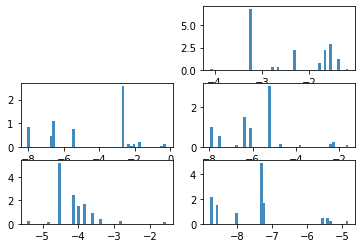

In [190]:
# Plot prior and posterior distributions

for i in range(5):    
    ax = plt.subplot(3, 2, i + 2)
    plt.hist(tf.reshape(samples[:,:,i], (-1,)).numpy(), histtype = 'stepfilled', bins = 50, alpha = 0.85,
             label = None, density = True)